In [2]:
import open3d as o3d
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import RealSense as real


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# https://platform.openai.com/docs/guides/vision
from openai import OpenAI
import base64
import requests
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
from transformers.image_utils import ImageFeatureExtractionMixin

In [4]:
def displayWorld(worldPCD):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    geometry.append(worldPCD)
    o3d.visualization.draw_geometries(geometry)


In [5]:
saved_pcd = o3d.io.read_point_cloud("rgbd_image_ur5.pcd")
displayWorld(saved_pcd)

In [104]:
# plot predictions
# https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb
SCORE_THRESHOLD = 0.01

def get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    pboxes = []
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      pboxes.append((pbox, text_queries[label]))
    return pboxes

def plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      print(pbox)
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

def encode_image(image_path):
    with open(f"{image_path}", "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [240]:
rsc = real.RealSense()
rsc.initConnection()

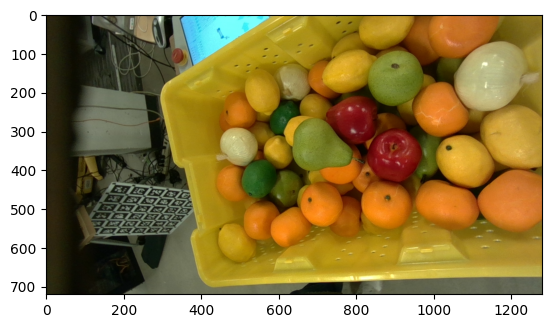

In [241]:
pcd,rgbdImage = rsc.getPCD()
plt.imshow(rgbdImage.color)

In [242]:
displayWorld(pcd)

In [10]:
# hf imports
# from LANGrasp: https://huggingface.co/docs/transformers/model_doc/owlvit
from transformers import OwlViTProcessor, OwlViTForObjectDetection
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [243]:
img_tensor = torch.tensor(np.asarray(rgbdImage.color), dtype=torch.float32)
img = np.asarray(rgbdImage.color)

In [244]:
pimg = Image.fromarray(img)
pimg.save("rgb_image_ur5.png")
o3d.io.write_point_cloud("rgbd_image_ur5.pcd", pcd)

True

In [245]:
# texts = [[" a photo of an apple", "a photo of a lemon"]]
# texts = ["a photo of an apple", "a photo of a lemon", "a photo of an onion", "a photo of a lime", "a photo of a pear"]
# texts = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear"]
texts = ["apple", "lemon", "lime", "pear"]

inputs = processor(texts, images=img_tensor, padding=True, return_tensors="pt")
outputs = model(**inputs)

In [246]:
np.asarray(rgbdImage.color).shape[:2]

(720, 1280)

In [247]:
target_sizes = torch.Tensor([img.shape[:2][::-1]])
target_sizes

tensor([[1280.,  720.]])

In [248]:
target_sizes = torch.Tensor([img.shape[:2][::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
b = boxes
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


Detected l with confidence 0.01 at location [452.81, 0.38, 537.17, 163.3]
Detected l with confidence 0.012 at location [334.76, 9.74, 432.64, 258.6]
Detected l with confidence 0.011 at location [232.4, -4.02, 714.96, 929.97]
Detected l with confidence 0.01 at location [397.54, 155.24, 476.8, 364.32]
Detected l with confidence 0.028 at location [463.34, 163.35, 552.51, 425.94]
Detected l with confidence 0.013 at location [625.6, 416.31, 721.05, 704.69]
Detected l with confidence 0.024 at location [349.17, 468.15, 452.25, 731.98]
Detected l with confidence 0.037 at location [351.13, 463.51, 452.11, 727.93]


[804.9910068511963, 0.21487712860107422, 954.9740505218506, 91.85794472694397]
[595.1219367980957, 5.480026602745056, 769.1312980651855, 145.46394646167755]
[413.16272735595703, -2.2595572471618652, 1271.031150817871, 523.107168674469]
[706.7330551147461, 87.32439458370209, 847.6529312133789, 204.93246853351593]
[823.7150573730469, 91.8844985961914, 982.2425842285156, 239.59284782409668]
[1112.1731758117676, 234.17243599891663, 1281.8707084655762, 396.3888967037201]
[620.7484912872314, 263.33381474018097, 804.0052318572998, 411.7401713132858]
[624.2333602905273, 260.72582244873047, 803.7459182739258, 409.4582176208496]


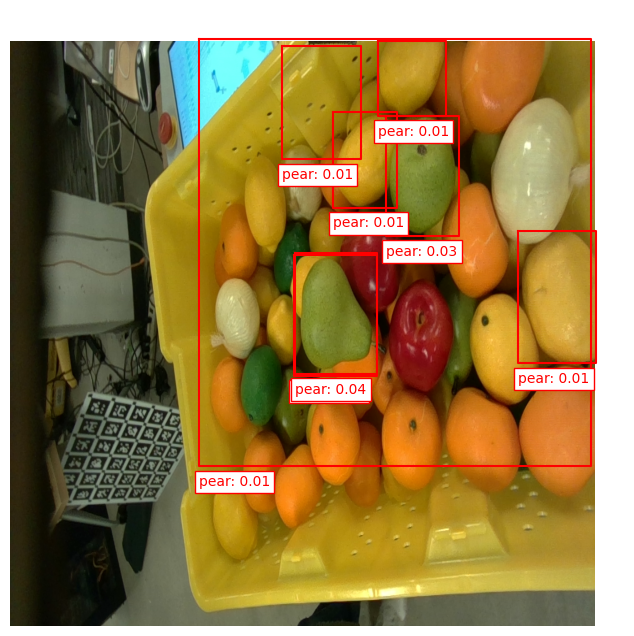

In [249]:
# Get prediction logits
def get_preds(outputs):
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()
    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    # boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    pboxes = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)[0]['boxes']
    return scores, labels, boxes, pboxes

scores, labels, boxes, pboxes = get_preds(outputs)
input_image = np.asarray(img).astype(np.float32) / 255.0
# text_queries = ["apple", "lemon", "lime", "pear", "onion"]
text_queries = ["apple", "lemon", "lime", "pear"]
plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=0.01)


In [251]:
boxes = get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=0.01)
len(boxes)

8

In [253]:
boxes[6]

([620.7484912872314, 263.33381474018097, 804.0052318572998, 411.7401713132858],
 'pear')

In [254]:
box = boxes[6][0]

x_min = int(box[0])
y_min = int(box[1])
x_max = int(box[2])
y_max = int(box[3])
# y_min = int(box[0])
# x_min = int(box[1])
# y_max = int(box[2])
# x_max = int(box[3])
x_center = (x_min + x_max) / 2
y_center = (y_min + y_max) / 2
bbox = x_min, y_min, x_max, y_max
bbox


(620, 263, 804, 411)

In [255]:
np.transpose(np.asarray(rgbdImage.color), (1, 0, 2)).shape
np.asarray(rgbdImage.depth).shape
np.asarray(rgbdImage)

array(RGBDImage of size 
Color image : 1280x720, with 3 channels.
Depth image : 1280x720, with 1 channels.
Use numpy.asarray to access buffer data., dtype=object)

In [256]:
depth_image = np.asarray(rgbdImage.depth)
# depth_values = depth_image[x_min:x_max, y_min:y_max]
depth_values = depth_image[y_min:y_max, x_min:x_max]
depth_o3d = o3d.geometry.Image((depth_values).astype(np.uint8))
rgb_image    = np.asarray(rgbdImage.color)
# rgb_values = np.asarray(rgbdImage.color)[x_min:x_max, y_min:y_max]
rgb_values = np.asarray(rgbdImage.color)[y_min:y_max, x_min:x_max]
rgb_o3d = o3d.geometry.Image((rgb_values).astype(np.uint8))

In [258]:
Image.fromarray(rgb_values).show()

In [259]:
Image.fromarray(depth_values).show()

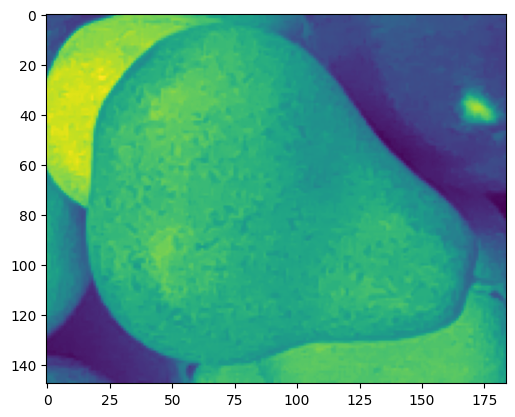

In [260]:
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)
plt.imshow(rgbd_image.color)

# cpcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image)

In [261]:
# Also, assuming x_min, x_max, y_min, y_max define your region of interest (ROI)

# Create masks for the region of interest
roi_mask_rgb = np.zeros_like(rgb_image, dtype=bool)
# roi_mask_rgb[x_min:x_max, y_min:y_max, :] = True
roi_mask_rgb[y_min:y_max, x_min:x_max, :] = True

roi_mask_depth = np.zeros_like(depth_image, dtype=bool)
# roi_mask_depth[x_min:x_max, y_min:y_max] = True
roi_mask_depth[y_min:y_max, x_min:x_max] = True

rgb_m_array = rgb_image
depth_m_array = depth_image
# Apply the masks to set values outside the ROI to 0
rgb_m_array[~roi_mask_rgb] = 255
depth_m_array[~roi_mask_depth] = 0
depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
rgb_m = o3d.geometry.Image((rgb_m_array).astype(np.uint8))

rgb_m_array.shape

(720, 1280, 3)

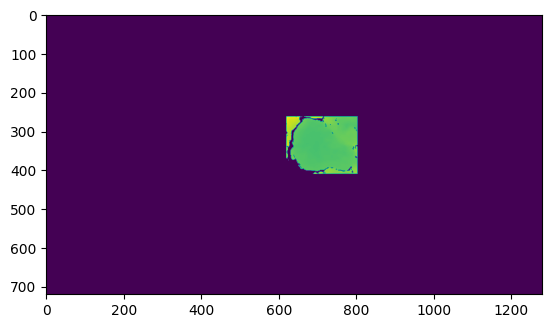

In [262]:
plt.imshow(depth_m_array)

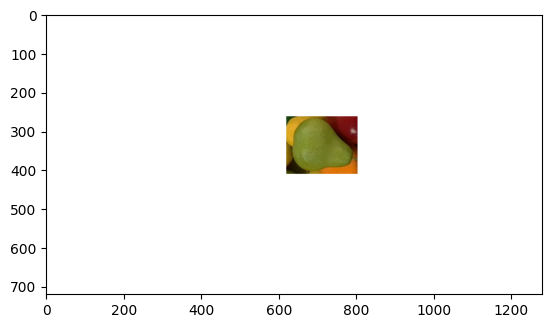

In [263]:
plt.imshow(rgb_m_array)

In [264]:
rgbd_m_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_m, depth_m)


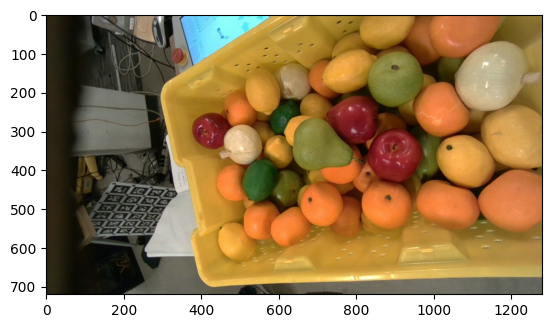

In [265]:
pcd,rgbdImage = rsc.getPCD()
plt.imshow(rgbdImage.color)

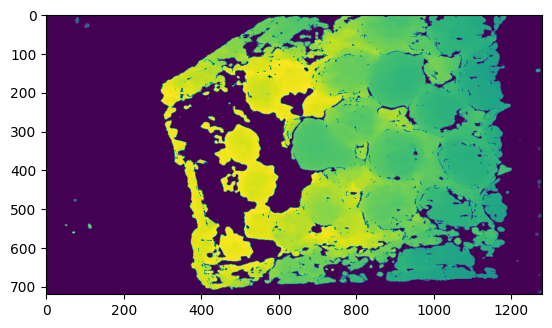

In [266]:
plt.imshow(rgbdImage.depth)

In [267]:
displayWorld(pcd)

In [268]:
# rgbdImage.color = rgbd_m_image.color
###
# This is the magic line
# find the depth mask from the OWL ViT bounding box
# reassign the orig rgbdImage
# then recreate the pcd
###
rgbdImage.depth = depth_m
# et voila
cpcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbdImage,
    # rgbd_m_image,
    rsc.pinholeInstrinsics,
    project_valid_depth_only=True,
    extrinsic=rsc.extrinsics
)

In [275]:
displayWorld(cpcd)

In [270]:
o3d.io.write_point_cloud("masked_rgbd_image_ur5.pcd", cpcd)


True

In [271]:
scpcd = o3d.io.read_point_cloud("masked_rgbd_image_ur5.pcd")
displayWorld(scpcd)

In [234]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [276]:
saved_pcd = o3d.io.read_point_cloud("masked_rgbd_image_ur5.pcd")
cl, ind = saved_pcd.remove_statistical_outlier(nb_neighbors=100, std_ratio=0.01)
inlier_cloud = saved_pcd.select_by_index(ind)
# display_inlier_outlier(saved_pcd, ind)
displayWorld(inlier_cloud)

In [273]:
mc = inlier_cloud.compute_mean_and_covariance()
mc

(array([ 0.04913553, -0.00977856,  0.36643119]),
 array([[ 6.73532478e-04, -2.72994456e-05,  1.46434876e-04],
        [-2.72994456e-05,  4.05506262e-04, -1.18058244e-05],
        [ 1.46434876e-04, -1.18058244e-05,  9.69451842e-05]]))

In [238]:
import rtde_control
import rtde_receive
from Motor_code import Motors
import UR5_Interface as ur
import RealSense as real
import numpy as np
import spatialmath as sm
import copy
import time
import math

try:
    robotIP = "192.168.0.6"
    con = rtde_control.RTDEControlInterface(robotIP)
    rec = rtde_receive.RTDEReceiveInterface(robotIP)
    servoPort = "/dev/ttyACM0"
    gripperController = Motors(servoPort)
    gripperController.torquelimit(600) # used to be 600
    gripperController.speedlimit(100)
    ur = ur.UR5_Interface()
    ur.gripperController = gripperController
    try:
        ur.c = con
        ur.r = rec
        ur.gripperController = gripperController
    except Exception as e:
        raise(e)
    else:
        print("UR5 + Gripper Interface Established")
    real = real.RealSense()
    real.initConnection()
    
    
    
    # TODO: why is this duplicate code from lines 42-52 with different goalDict
    
    # urPose = ur.getPose()
    # pcd,rgbdImage = detector.real.getPCD()
    # depthImage,colorImage = rgbdImage.depth,rgbdImage.color
    # blocks = detector.getBlocksFromImages(colorImage,depthImage,urPose,display = True)

    # planner = tp.TaskPlanner(blocks)
    # goalDict = {"on":[("blueBlock","yellowBlock"),("redBlock", "yellowBlock")]}
    # steps = planner.generatePlan(goalDict)
    # print(steps)
    # for block in blocks:
    #     print(f"{block.name} - {list(block.gripperFrameCoords)}")
    
    sleepRate = 0.75
    def projectToWorldCoords(gripperFrameCoords):
        # given a goal position in gripper coords returns the displacements from the current pose in world coords
        xB,yB,zB = gripperFrameCoords
        # subtract 0.165 from block position in gripper frame to account for gripper length
        zB -= 0.155
        currentPose = ur.getPose() #SE3 Object
        # print(f"Current Pose:\n{currentPose*1000}")
        R = currentPose.R 
        pX,pY,pZ = tuple(currentPose.t)
        # xB,yB,zB here is the block position in the gripper frame which is aligned with the optoforce frame
        P_goal = np.matmul(R,np.array([xB,yB,zB]).T)  # relative position of the block in world coordinates
        print(f"P_goal:\n{P_goal}")
        dX,dY,dZ = tuple(P_goal) # quantities and directions the the gripper frame should be incremented to be centered at the block 
        return dX,dY,dZ
        
    def moveToBlock(blockPos):
        # would be better if this was block object
        # :blockPos is coord in gripper frame
        dX,dY,dZ = projectToWorldCoords(blockPos) # goalPose in world coordinates
        homePose = ur.getPose()
        dZ  += 7/1000 # up 7 mm to avoid hitting lower block
        goal1 = copy.deepcopy(homePose)
        goal1.t[2] += dZ
        ur.moveL(goal1)
        time.sleep(sleepRate)
        goal2 = goal1
        goal2.t[0] += dX
        goal2.t[1] += dY
        ur.moveL(goal2)
        time.sleep(sleepRate)
        
    def moveBackFromBlock(homePose):    
        currentPose = ur.getPose()
        # Move up 3 mm to avoid raise block to prevent friction from toppling lower block
        goal1 = copy.deepcopy(currentPose)
        goal1.t[2] -= 3/1000
        ur.moveL(goal1)
        time.sleep(sleepRate)
        currentPose = ur.getPose()
        dX,dY,dZ = tuple(homePose.t - currentPose.t)
        # Move in the XY Plane then Z Axis
        goal2 = copy.deepcopy(currentPose)
        goal2.t[0] += dX
        goal2.t[1] += dY
        ur.moveL(goal2)
        time.sleep(sleepRate)
        # Move in Z Axis back to home
        goal3 = copy.deepcopy(goal2)
        goal3.t[2] += dZ
        ur.moveL(goal3)
        time.sleep(sleepRate)

    
    # print(f"res: {projectToWorldCoords(res)} ")
    # ur.openGripper() # Open gripper
    # ur.testRoutine()
    homePose = ur.getPose()
    x_mod = 0.0
    y_mod = 0.0
    z_mod = 0.0
    grabPos = inlier_cloud.compute_mean_and_covariance()
    moveToBlock(grabPos) 
    print("Done moving to block")
    ur.closeGripper(9) 
    time.sleep(sleepRate)
    moveBackFromBlock(homePose)
    ur.openGripper()
    gripperController.openGripper()
    gripperController.disconnect()
    ur.c.disconnect()
    ur.r.disconnect()
    real.disconnect()
except Exception as e:
    gripperController.openGripper()
    gripperController.disconnect()
    ur.c.disconnect()
    ur.r.disconnect()
    real.disconnect()
    raise(e)

ModuleNotFoundError: No module named 'Motor_code'